Imports

In [28]:
import csv
import time
from IPython import display
import random
import os
from tqdm import tqdm  # Progress bar
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE  # Data projection
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, AdamW, TrainingArguments, Trainer, pipeline  # Transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch  # Neural Networks
import re
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import json
import fasttext.util
import fasttext  # Static word embeddings
import roner
!pip install roner
!pip install fasttext
!pip install transformers
!pip install scikit-multilearn


sns.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Seeding

In [2]:
seed = 31
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
!unzip "/content/drive/MyDrive/nitro-lang-processing-1.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/nitro-lang-processing-1.zip
  inflating: /content/data/random_seed_setter.py  
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/tag_to_id.json  
  inflating: /content/data/teams_rand_seed.csv  
  inflating: /content/data/test.json  
  inflating: /content/data/train.json  


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = "/content/drive/MyDrive/nitro-lang-processing-1.zip"
train_path = "train.json"
# train_path = "/content/data/train.json" # uncomment this line if running from collab
test_path = "test.json"
# test_path = "/content/data/test.json" # uncomment this line if running from collab

train_json = None
test_json = None
with open(train_path, "r") as f:
    train_json = json.load(f)
with open(test_path, "r") as f:
    test_json = json.load(f)
PAD = 'PAD'

tag_to_id = {"O": 0, "PERSON": 1, "QUANTITY": 12, "NUMERIC": 13, "NAT_REL_POL": 5, "GPE": 3, "DATETIME": 9, "ORG": 2,
             "PERIOD": 10, "EVENT": 6, "FACILITY": 15, "ORDINAL": 14, "LOC": 4, "MONEY": 11, "WORK_OF_ART": 8, "LANGUAGE": 7}


# Datasets and dataloaders

In [5]:
from typing import Iterable

class HackathonDataset(Dataset):
  def __init__(self, json_f):
    self.json_f = json_f
    self.tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-ner")

  def __len__(self):
    return len(self.json_f)

  def __getitem__(self, idx):
    if not isinstance(idx, Iterable):
      idx = [idx]
    data = []
    targets = []
    for id in idx:
      json_item = self.json_f[id]
      ids = json_item["ner_ids"][:120]
      
      # Remove cedilla diacritics as suggested in
      # https://huggingface.co/dumitrescustefan/bert-base-romanian-uncased-v1
      # We changed some special characters to custom tokens to avoid losing them after tokenisation
      filtered_tokens = [
        text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș").replace("\n", "NTOK").
          replace(' ', "WS").replace("\xa0", "WS") for text in
                         json_item["tokens"]]

      # The maximum length is 120 because the longest sentence in the test dataset has length 100 and tokenisation can extend its size.
      tokenized_bert = self.tokenizer(filtered_tokens, add_special_tokens=True, max_length=120, padding='max_length',
                                      return_tensors='pt', truncation=True, is_split_into_words=True)
      word_ids = tokenized_bert.word_ids()
      data.append(tokenized_bert["input_ids"].squeeze(0))
      aligned_ids = [0 if tok is None else ids[tok] for tok in word_ids]
      targets.append(torch.as_tensor(aligned_ids).squeeze(0))
    return torch.stack(data), torch.stack(targets)

  def targets(self):
    # We use thie method for data stratification
    targets = []
    for idx in range(len(self.json_f)):
      ids = self.json_f[idx]["ner_ids"][:120]
      if len(ids) < 120:
        ids.extend([0 for i in range(120 - len(ids))])

      targets.append(ids)
    return targets

In [34]:
class HackathonTestDataset(Dataset):
  def __init__(self, json_f):
    self.json_f = json_f
    self.tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-ner")

  def __len__(self):
    return len(self.json_f)

  def __getitem__(self, idx):
    if not isinstance(idx, Iterable):
      idx = [idx]
    data = []
    for id in idx:
      json_item = self.json_f[id]

      # Remove cedilla diacritics as suggested in
      # https://huggingface.co/dumitrescustefan/bert-base-romanian-uncased-v1
      # We changed some special characters to custom tokens to avoid losing them after tokenisation
      filtered_tokens = [
        text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș").replace("\n", "NTOK").
          replace(' ', "WS").replace("\xa0", "WS") for text in
                         json_item["tokens"]]

      # The maximum length is 120 because the longest sentence in the test dataset has length 100 and tokenisation can extend its size.
      tokenized_bert = self.tokenizer(filtered_tokens, add_special_tokens=True, max_length=120, padding='max_length',
                                      return_tensors='pt', truncation=True, is_split_into_words=True)
      data.append((tokenized_bert["input_ids"].squeeze(0), tokenized_bert.word_ids(), filtered_tokens))
    return data

In [35]:
# we will need a special type of collation for our test dataloader, since it returns tuples of (embeddings, word_ids and original tokens)
# original tokens are returned for debugging purposes
def collate_fn(data):
    tokens = []
    word_inds = []
    words_original = []
    for idx in range(len(data)):
        tokens.append(data[idx][0][0])
        word_inds.append(data[idx][0][1])
        words_original.append(data[idx][0][2])
    return tokens, word_inds, words_original

In [36]:
ds_train = HackathonDataset(train_json)

indices = np.asarray([x for x in range(len(ds_train))])
indices = indices[..., np.newaxis] # N x len(ds_train) -> 1 x len(ds_train)

targets = ds_train.targets()
train_idx, _, val_idx, _ = iterative_train_test_split(indices, np.asarray(targets), test_size=0.2)
train_set = torch.utils.data.Subset(ds_train, train_idx)
val_set = torch.utils.data.Subset(ds_train, val_idx)

ds_test = HackathonTestDataset(test_json)

BATCH_SIZE=32
dl_train = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True
)
dl_valid = DataLoader(
  val_set, batch_size=BATCH_SIZE, shuffle=False
)
dl_test = DataLoader(
    ds_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

# Transformer Model

In [19]:
class TransformerModel(nn.Module):
  def __init__(self, num_classes=16):
      super(TransformerModel, self).__init__()
      # Get the romanian Transformer from the huggingface server
      self.transformer = AutoModelForTokenClassification.from_pretrained("dumitrescustefan/bert-base-romanian-ner")
      # Add a linear layer to convert BIO2 classes to the classes from our task
      self.fc = nn.Linear(31, num_classes)

  def forward(self, x):
      out = x.squeeze(1)
      # Get output from Transformer.
      out = self.transformer(out)[0]
      out = self.fc(out)
      return out

In [24]:
# Instantiate our model and move it to GPU
model = TransformerModel().to(device)

# Freeze all the Transformer parameters
for p in model.transformer.parameters():
  p.requires_grad = False
# Unfreeze bias terms
trainable_params_transformer = [p for (n, p) in model.transformer.named_parameters() if "bias" in n]
for p in trainable_params_transformer:
  p.requires_grad = True

trainable_params = list(model.fc.parameters())
trainable_params.extend(list(trainable_params_transformer))


# Loss function and optimizer

In [25]:
# We used weights proportional to each class from the train dataset
weights = torch.as_tensor([1, 32, 62, 100, 227, 250, 357, 2000, 181, 58, 357, 352, 476, 158, 416, 384 ]).float().to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)
# We'll use AdamW for the Transformer
optim = AdamW(trainable_params)

C:\Users\Dragos\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training and testing functions


In [22]:
def train_epoch(model, optim, loss_fn, dataloader):
    """ Trains the model for one epoch and returns the loss together with a classification report.
    """

    epoch_loss = 0
    model.train()
    preds = []
    gt = []

    times = []
    for idx, batch in enumerate(dataloader):
        # get rough estimate of eta
        beg = time.time()
        optim.zero_grad()

        inputs, labels = batch
        # Move data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)

        output = model(inputs.to(device))
        output = output.reshape(-1, 16)
        labels = labels.reshape(-1)
        # Calculate the loss and backpropagate
        loss = loss_fn(output, labels)
        loss.backward()
        # Update weights
        optim.step()

        final = time.time()
        times.append(final - beg)
        # print a message every 10 batches
        if idx % 10 == 0:
            print(
                f"Loss is {loss}, time left = {(sum(times) / len(times) * (len(dataloader.dataset) - idx * BATCH_SIZE - BATCH_SIZE)) / 60} minutes.")

        epoch_loss += loss.item()

        # compute accuracy and other metrics
        probs = F.softmax(output, dim=-1)
        batch_preds = torch.argmax(probs, dim=1)

        preds.append(batch_preds.cpu().numpy())
        gt.append(labels.cpu().numpy())

    # Average the epoch losses
    epoch_loss /= len(dataloader)

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)

    print(f"Acc on train: {round(accuracy_score(gt, preds) * 100, 4)}%")
    # Get an epoch classification report
    clf_report = classification_report(gt, preds, output_dict=True)

    return epoch_loss, clf_report


@torch.inference_mode()
def evaluate(model, loss_fn, dataloader):
    """ Computes and returns the loss and classification report for a testing dataset.
    """

    test_loss = 0
    model.eval()
    preds = []
    gt = []

    for idx, batch in enumerate(dataloader):
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model(inputs)

        output = output.reshape(-1, 16)
        labels = labels.reshape(-1)
        test_loss += loss_fn(output, labels).item()

        # compute accuracy and other metrics
        probs = F.softmax(output, dim=-1)
        batch_preds = torch.argmax(probs, dim=1)

        preds.append(batch_preds.cpu().numpy())
        gt.append(labels.cpu().numpy())

    test_loss /= len(dataloader)
    preds = np.concatenate(preds)
    gt = np.concatenate(gt)

    print(f"Acc on val: {round(accuracy_score(gt, preds) * 100, 4)}%")
    # Get a classification report
    clf_report = classification_report(gt, preds, output_dict=True)
    clf_report_text = classification_report(gt, preds)

    return test_loss, clf_report, clf_report_text


  0%|          | 0/5 [00:00<?, ?it/s]

Loss is 3.334688901901245, time left = 6.467365713914235 minutes.
Loss is 3.179453134536743, time left = 5.584354591369629 minutes.
Loss is 2.6458547115325928, time left = 5.456521452987006 minutes.
Loss is 2.252753973007202, time left = 5.172382919890906 minutes.
Loss is 1.9162737131118774, time left = 4.979058006333142 minutes.
Loss is 1.7526006698608398, time left = 4.853657495196348 minutes.
Loss is 1.481388807296753, time left = 4.626525648500098 minutes.
Loss is 1.3232855796813965, time left = 4.422441379620995 minutes.
Loss is 1.25190007686615, time left = 4.22878046541057 minutes.
Loss is 1.1315803527832031, time left = 4.045017530018594 minutes.
Loss is 1.0919380187988281, time left = 3.853197249445585 minutes.
Loss is 0.9279797673225403, time left = 3.6675237313763156 minutes.
Loss is 0.7927250266075134, time left = 3.48980353384307 minutes.
Loss is 0.649086058139801, time left = 3.3195700460717874 minutes.
Loss is 0.650360107421875, time left = 3.1381333853336093 minutes.
Lo

Epoch: 1, t_loss: 0.940, v_loss: 0.174, t_acc: 84.50, v_acc: 95.33:   0%|          | 0/5 [03:19<?, ?it/s]


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    272002
           1       0.78      0.98      0.87     11326
           2       0.77      0.97      0.86      5899
           3       0.86      0.94      0.90      4117
           4       0.74      0.95      0.83      1835
           5       0.64      0.97      0.77      1492
           6       0.55      0.97      0.70      1056
           7       0.65      1.00      0.79       186
           8       0.66      0.98      0.79      1815
           9       0.63      0.97      0.76      5009
          10       0.77      0.99      0.87      1062
          11       0.90      1.00      0.95      1201
          12       0.83      0.99      0.90       909
          13       0.55      0.95      0.69      2032
          14       0.69      0.98      0.81       791
          15       0.73      0.95      0.83       908

    accuracy                           0.95    311640
   macro avg       0.73  

Epoch: 1, t_loss: 0.940, v_loss: 0.174, t_acc: 84.50, v_acc: 95.33:  20%|██        | 1/5 [03:20<13:21, 200.33s/it]

Loss is 0.2334751933813095, time left = 8.08990265528361 minutes.
Loss is 0.23366284370422363, time left = 7.364949473467741 minutes.
Loss is 0.1988409012556076, time left = 7.083904111763788 minutes.
Loss is 0.27558982372283936, time left = 6.566007530689239 minutes.
Loss is 0.2521366477012634, time left = 6.223681314398602 minutes.
Loss is 0.16736885905265808, time left = 6.128880907819163 minutes.
Loss is 0.22696618735790253, time left = 5.931379936627352 minutes.
Loss is 0.1231398731470108, time left = 5.718175484428943 minutes.
Loss is 0.21492581069469452, time left = 5.401412564736826 minutes.
Loss is 0.19383032619953156, time left = 5.060936072021177 minutes.
Loss is 0.28389212489128113, time left = 4.757862386018924 minutes.
Loss is 0.2932121753692627, time left = 4.43440982754882 minutes.
Loss is 0.16530923545360565, time left = 4.145626644030747 minutes.
Loss is 0.13988906145095825, time left = 3.8710873996938457 minutes.
Loss is 0.17139671742916107, time left = 3.60542183722

Epoch: 2, t_loss: 0.169, v_loss: 0.102, t_acc: 95.53, v_acc: 94.48:  20%|██        | 1/5 [06:31<13:21, 200.33s/it]


              precision    recall  f1-score   support

           0       1.00      0.94      0.97    272002
           1       0.74      0.99      0.85     11326
           2       0.69      0.97      0.81      5899
           3       0.83      0.96      0.89      4117
           4       0.68      0.95      0.79      1835
           5       0.61      0.98      0.75      1492
           6       0.42      0.99      0.59      1056
           7       0.67      0.98      0.80       186
           8       0.63      0.98      0.77      1815
           9       0.64      0.98      0.77      5009
          10       0.80      0.99      0.89      1062
          11       0.90      1.00      0.95      1201
          12       0.70      1.00      0.82       909
          13       0.63      0.92      0.75      2032
          14       0.67      0.98      0.80       791
          15       0.64      0.96      0.77       908

    accuracy                           0.94    311640
   macro avg       0.70  

Epoch: 2, t_loss: 0.169, v_loss: 0.102, t_acc: 95.53, v_acc: 94.48:  40%|████      | 2/5 [06:32<09:46, 195.43s/it]

Loss is 0.0916307121515274, time left = 7.443062003453573 minutes.
Loss is 0.1250632405281067, time left = 6.554146385192871 minutes.
Loss is 0.18654349446296692, time left = 6.099063020849985 minutes.
Loss is 0.1290571689605713, time left = 5.837658224823654 minutes.
Loss is 0.07870502769947052, time left = 5.559865295305484 minutes.
Loss is 0.17349396646022797, time left = 5.30056237262838 minutes.
Loss is 0.1166318878531456, time left = 5.085911807271301 minutes.
Loss is 0.1038362979888916, time left = 4.846450685111569 minutes.
Loss is 0.1434953659772873, time left = 4.590515667568018 minutes.
Loss is 0.05351119115948677, time left = 4.3402679552962065 minutes.
Loss is 0.07002243399620056, time left = 4.103652493788465 minutes.
Loss is 0.13334804773330688, time left = 3.87113204721932 minutes.
Loss is 0.09348694980144501, time left = 3.645842173276854 minutes.
Loss is 0.09609520435333252, time left = 3.4295322552892085 minutes.
Loss is 0.13803835213184357, time left = 3.21875650544

Epoch: 3, t_loss: 0.119, v_loss: 0.078, t_acc: 96.09, v_acc: 96.64:  40%|████      | 2/5 [09:42<09:46, 195.43s/it]


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    272002
           1       0.85      0.99      0.91     11326
           2       0.75      0.98      0.85      5899
           3       0.91      0.97      0.94      4117
           4       0.83      0.94      0.88      1835
           5       0.62      0.99      0.77      1492
           6       0.53      0.98      0.69      1056
           7       0.83      0.96      0.89       186
           8       0.77      0.98      0.86      1815
           9       0.78      0.98      0.87      5009
          10       0.91      0.99      0.95      1062
          11       0.94      1.00      0.97      1201
          12       0.88      0.99      0.93       909
          13       0.65      0.97      0.78      2032
          14       0.70      1.00      0.82       791
          15       0.72      0.97      0.83       908

    accuracy                           0.97    311640
   macro avg       0.79  

Epoch: 3, t_loss: 0.119, v_loss: 0.078, t_acc: 96.09, v_acc: 96.64:  60%|██████    | 3/5 [09:43<06:26, 193.27s/it]

Loss is 0.07011991739273071, time left = 6.466633296012878 minutes.
Loss is 0.11017187684774399, time left = 5.412563018365341 minutes.
Loss is 0.09026029706001282, time left = 5.226187749703725 minutes.
Loss is 0.10510905086994171, time left = 5.074335531650051 minutes.
Loss is 0.08160026371479034, time left = 4.873470555572975 minutes.
Loss is 0.0758148580789566, time left = 4.681600001045301 minutes.
Loss is 0.052642159163951874, time left = 4.488743862363159 minutes.
Loss is 0.04857543110847473, time left = 4.3020372264821765 minutes.
Loss is 0.047042474150657654, time left = 4.121272675049158 minutes.
Loss is 0.07420386373996735, time left = 3.934847220352718 minutes.
Loss is 0.10124928504228592, time left = 3.7445630145545055 minutes.
Loss is 0.058865681290626526, time left = 3.558596858140584 minutes.
Loss is 0.06270129978656769, time left = 3.376255375360326 minutes.
Loss is 0.08736516535282135, time left = 3.1941829982604686 minutes.
Loss is 0.13808394968509674, time left = 3.

Epoch: 4, t_loss: 0.098, v_loss: 0.077, t_acc: 96.67, v_acc: 96.74:  60%|██████    | 3/5 [12:46<06:26, 193.27s/it]


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    272002
           1       0.88      0.99      0.93     11326
           2       0.75      0.98      0.85      5899
           3       0.92      0.98      0.95      4117
           4       0.87      0.91      0.89      1835
           5       0.70      0.99      0.82      1492
           6       0.44      0.99      0.61      1056
           7       0.84      0.96      0.90       186
           8       0.70      0.99      0.82      1815
           9       0.78      0.98      0.87      5009
          10       0.88      0.99      0.93      1062
          11       0.94      1.00      0.97      1201
          12       0.88      1.00      0.93       909
          13       0.73      0.97      0.83      2032
          14       0.73      1.00      0.85       791
          15       0.60      0.99      0.75       908

    accuracy                           0.97    311640
   macro avg       0.79  

Epoch: 4, t_loss: 0.098, v_loss: 0.077, t_acc: 96.67, v_acc: 96.74:  80%|████████  | 4/5 [12:46<03:09, 189.58s/it]

Loss is 0.05339757725596428, time left = 6.299603466192881 minutes.
Loss is 0.10466174781322479, time left = 5.5261350935155695 minutes.
Loss is 0.1013132780790329, time left = 5.290407272936806 minutes.
Loss is 0.12897558510303497, time left = 5.068671711798638 minutes.
Loss is 0.10077422857284546, time left = 4.869357172163521 minutes.
Loss is 0.06889545917510986, time left = 4.67569020729439 minutes.
Loss is 0.0820598155260086, time left = 4.509114866243686 minutes.
Loss is 0.05960126221179962, time left = 4.325681197139578 minutes.
Loss is 0.03152429312467575, time left = 4.138545120203937 minutes.
Loss is 0.12410685420036316, time left = 3.95571776667794 minutes.
Loss is 0.046924199908971786, time left = 3.7957272694842654 minutes.
Loss is 0.10269570350646973, time left = 3.6140190622470043 minutes.
Loss is 0.06556186825037003, time left = 3.4318020390741752 minutes.
Loss is 0.04118809103965759, time left = 3.2440987124697855 minutes.
Loss is 0.04965720698237419, time left = 3.052

Epoch: 5, t_loss: 0.086, v_loss: 0.066, t_acc: 96.88, v_acc: 96.76:  80%|████████  | 4/5 [15:53<03:09, 189.58s/it]


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    272002
           1       0.88      0.99      0.93     11326
           2       0.80      0.98      0.88      5899
           3       0.94      0.96      0.95      4117
           4       0.76      0.96      0.85      1835
           5       0.67      0.99      0.80      1492
           6       0.47      0.99      0.64      1056
           7       0.75      0.97      0.85       186
           8       0.61      0.99      0.76      1815
           9       0.84      0.98      0.91      5009
          10       0.85      0.99      0.91      1062
          11       0.90      1.00      0.95      1201
          12       0.83      1.00      0.91       909
          13       0.69      0.97      0.80      2032
          14       0.73      1.00      0.85       791
          15       0.61      0.99      0.76       908

    accuracy                           0.97    311640
   macro avg       0.77  

Epoch: 5, t_loss: 0.086, v_loss: 0.066, t_acc: 96.88, v_acc: 96.76: 100%|██████████| 5/5 [15:54<00:00, 190.95s/it]


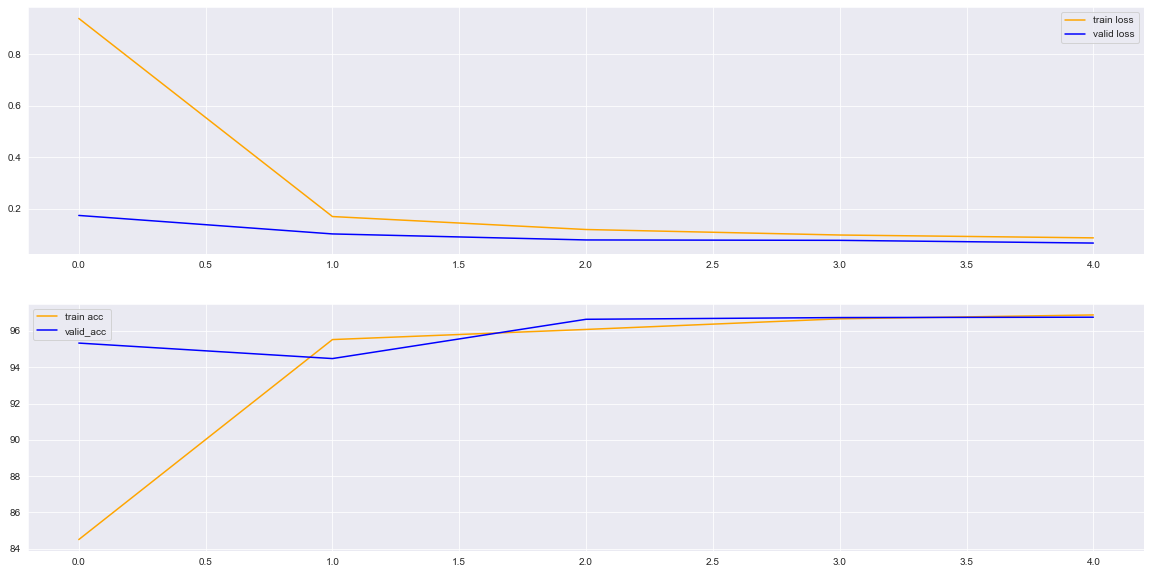

In [26]:
num_epochs = 5  # train for 5 epochs
best_val_loss = None

pbar = tqdm(range(num_epochs))

train_losses = []
val_losses = []

train_accs = []
val_accs = []

for e in pbar:
    train_loss, clf_report_train = train_epoch(model, optim, loss_fn, dl_train)
    val_loss, clf_report_val, clf_text = evaluate(model, loss_fn, dl_valid)
    print("\n" + clf_text)

    train_acc = clf_report_train['accuracy'] * 100
    val_acc = clf_report_val['accuracy'] * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    pbar.set_description(
        "Epoch: %s, t_loss: %.3f, v_loss: %.3f, t_acc: %.2f, v_acc: %.2f" % (
            e + 1, train_loss, val_loss, train_acc, val_acc))

    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_transformer_model.pt')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(num_epochs), train_losses, color='orange', label='train loss')
ax[0].plot(range(num_epochs), val_losses, color='blue', label='valid loss')
ax[1].plot(range(num_epochs), train_accs, color='orange', label='train acc')
ax[1].plot(range(num_epochs), val_accs, color='blue', label='valid_acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()


# Write final results

In [37]:
@torch.inference_mode()
def write_submission(model, dl_test):
    model.eval()

    with open("submission.csv", "w") as f:
        writer = csv.writer(f)
        header = ['Id', 'ner_label']
        writer.writerow(header)

    id = 0
    for batch in tqdm(dl_test):

        inputs, indices, original_words = batch
        inputs = torch.stack(inputs)
        inputs = inputs.to(device)

        outputs = model(inputs)
        outputs = outputs.reshape(-1, 16)

        probs = F.softmax(outputs, dim=-1)
        input = inputs.to("cpu").reshape(-1)
        indices = sum(indices, []) # trick to get flatten the list
        batch_preds = torch.argmax(probs, dim=1)
        for idx, (pred, token, idw) in enumerate(zip(batch_preds, input, indices)):
            # skip padding, CLS and other special BERT tokens
            if idw is None:
                continue
            if idx > 0  and indices[idx - 1] == idw: # skip subwords of the same word (i.e. eating-> eat ###ing, we will only take eat into account for final class)
                continue
            with open("submission.csv", "a", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow((id, pred.item()))
            id += 1

write_submission(model, dl_test)

100%|██████████| 76/76 [00:41<00:00,  1.85it/s]


# Confusion Matrix

In [ ]:
model.eval()
with torch.inference_mode():
    preds = []
    gt = []
    for inputs, targets in dl_valid:

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)

        output = output.reshape(-1, 16)
        targets = targets.reshape(-1)

        # compute accuracy and other metrics
        probs = F.softmax(output, dim=-1)
        batch_preds = torch.argmax(probs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        gt.extend(targets.cpu().numpy())

cf_matrix = confusion_matrix(gt, preds)
# sn.heatmap(cf_matrix, annot=True, fmt='d')


<AxesSubplot:>

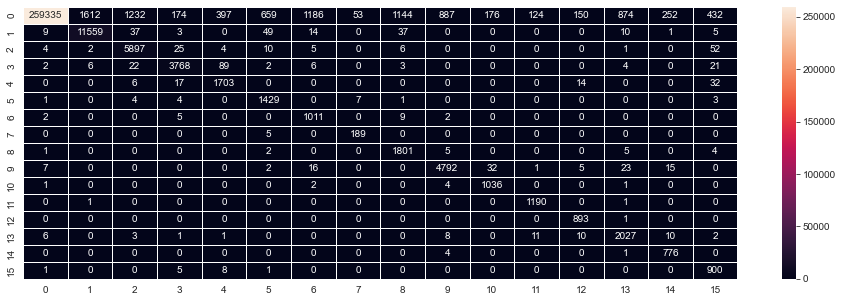

In [41]:
plt.figure(figsize = (16,5))
sn.heatmap(cf_matrix, annot=True, fmt='d', linewidths=.5)